<a href="https://colab.research.google.com/github/tranhamduong/CS2224.BaiTapTuan05/blob/main/Assignment_Week05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Họ và tên: Trần Hàm Dương

Mã học viên: CH2001026

# 1. PREPARATION


In [1]:
# install packages
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 75 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
# IMPORT
from numpy import zeros, resize, sqrt, histogram, hstack, vstack, savetxt, zeros_like
   
from os.path import exists, isdir, basename, join, splitext
from glob import glob
from numpy import zeros, resize, sqrt, histogram, hstack, vstack, savetxt, zeros_like
import scipy.cluster.vq as vq
import argparse
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler
import os
from tqdm import tqdm
import scipy.cluster.vq as vq
import pickle

In [4]:
# ************************************* # 
# MANUAL EXTRACTED SIFT FEATURES 
# ************************************* # 

# def extractSift(input_files):
#     print("extracting Sift features")
#     all_features_dict = {}
#     for i, fname in enumerate(input_files):
#       img = cv2.imread(fname)
#       keypoints, descriptors = sift.detectAndCompute(img, None)
#       all_features_dict[fname] = descriptors
#     return all_features_dict

# %cd /content
# !gdown --id 1LKsL4j0u8cCctiK3ARGkwHIdj-Y0d6Eg -O 1000-images-vnexpress.zip
# !unzip 1000-images-vnexpress.zip
# img_dir = '/content/1000-images-vnexpress' # change directory to 1000-images directory

# input_files = [os.path.join(img_dir, str(fname)) for fname in os.listdir(img_dir)]
# sift_features = extractSift(input_files)

# ************************************* # 
# OR USING PRE-EXTRACTED SIFT FEATURES
# ************************************* # 

!gdown --id 1QXGiFSoqRmD6vtrL9x3it1v8SKpYTE8G -O vnexpress_dataset_keypoints.pickle
with open('/content/vnexpress_dataset_keypoints.pickle', 'rb') as handle:
    sift_features = pickle.load(handle)

Downloading...
From: https://drive.google.com/uc?id=1QXGiFSoqRmD6vtrL9x3it1v8SKpYTE8G
To: /content/vnexpress_dataset_keypoints.pickle
100% 1.24G/1.24G [00:06<00:00, 180MB/s]


In [5]:
features_array = np.vstack(np.array(list(sift_features.values())))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [6]:
print(features_array.shape)
print(len(features_array))

(2428121, 128)
2428121


In [7]:
# ************************************* # 
# FIT EXTRACTED FEATURES INTO KMEANS, SINCE KMEANS CLUSTERS VERY SLOW (OVER 45 MIN FOR 100 N_CLUSTER, EVEN CRASH WITH HIGHER N_CLUSTER) ==> USING MINIBATCHKMEANS FOR BETTER PERFORMANCE
# ************************************* # 
kmeans = MiniBatchKMeans(n_clusters = 200)
kmeans.fit(
   features_array
)

MiniBatchKMeans(n_clusters=200)

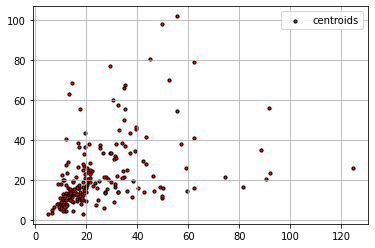

In [8]:
# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=10,
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [9]:
# Ki
print(len(kmeans.cluster_centers_))

200


In [10]:
image_w_cluster_indexing = dict()

for fname in tqdm(sift_features.keys()):
  # res = kmeans.predict(np.array(sift_features[fname], dtype=np.float64))
  res = kmeans.predict(sift_features[fname])
  if res.size == 0:
    continue
  
  image_w_cluster_indexing[fname] = []
  for cluster_id in res:
    image_w_cluster_indexing[fname].append(str(cluster_id))

with open('/content/image_w_cluster_indexing.pickle', 'wb') as f:
  pickle.dump(image_w_cluster_indexing, f, protocol=pickle.HIGHEST_PROTOCOL)

print(len(image_w_cluster_indexing))

100%|██████████| 1035/1035 [00:09<00:00, 113.02it/s]


1035


# 2. Using Whoosh for indexing


In [11]:
!pip install Whoosh
%cd /content
import os
os.mkdir('indexdir')

     |████████████████████████████████| 468 kB 5.1 MB/s 
/content


In [12]:
from whoosh.index import create_in
from whoosh.fields import *
schema = Schema(path=ID(stored=True), content=TEXT(stored = True))
ix = create_in("indexdir", schema)
writer = ix.writer()

for item in image_w_cluster_indexing:
  writer.add_document(path=item, content= " ".join(image_w_cluster_indexing[item]))

writer.commit()
from whoosh.qparser import QueryParser

In [13]:
print(image_w_cluster_indexing['2IIYEAUBBW.jpg'])

['111', '47', '44', '49', '141', '141', '131', '141', '92', '146', '16', '58', '21', '185', '180', '49', '25', '35', '44', '188', '31', '85', '135', '0', '99', '21', '75', '43', '191', '129', '178', '126', '116', '161', '138', '21', '2', '69', '44', '3', '135', '109', '143', '49', '159', '59', '130', '142', '20', '120', '34', '61', '89', '19', '78', '59', '32', '116', '36', '67', '31', '10', '21', '180', '131', '16', '20', '88', '10', '31', '147', '69', '157', '38', '31', '10', '70', '90', '160', '31', '159', '159', '191', '131', '3', '78', '168', '108', '110', '172', '80', '28', '112', '69', '186', '119', '87', '122', '114', '193', '107', '136', '71', '9', '199', '155', '193', '33', '149', '70', '52', '109', '159', '159', '94', '80', '49', '180', '107', '169', '169', '153', '123', '176', '118', '157', '84', '44', '183', '151', '46', '159', '159', '172', '90', '90', '53', '65', '31', '126', '195', '118', '157', '165', '159', '159', '109', '22', '25', '46', '125', '21', '175', '182', '1

# 3. INFERENCING STAGE

In [14]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open('input.jpg', 'wb') as f:
      f.write(data)
      print ('saved file', name)
  return fname

Saving vie-t-nam-a-n-mu-ng-jpeg-16441-2665-8263-1644140829.jpg to vie-t-nam-a-n-mu-ng-jpeg-16441-2665-8263-1644140829.jpg
saved file vie-t-nam-a-n-mu-ng-jpeg-16441-2665-8263-1644140829.jpg
Uploaded done, showing image!


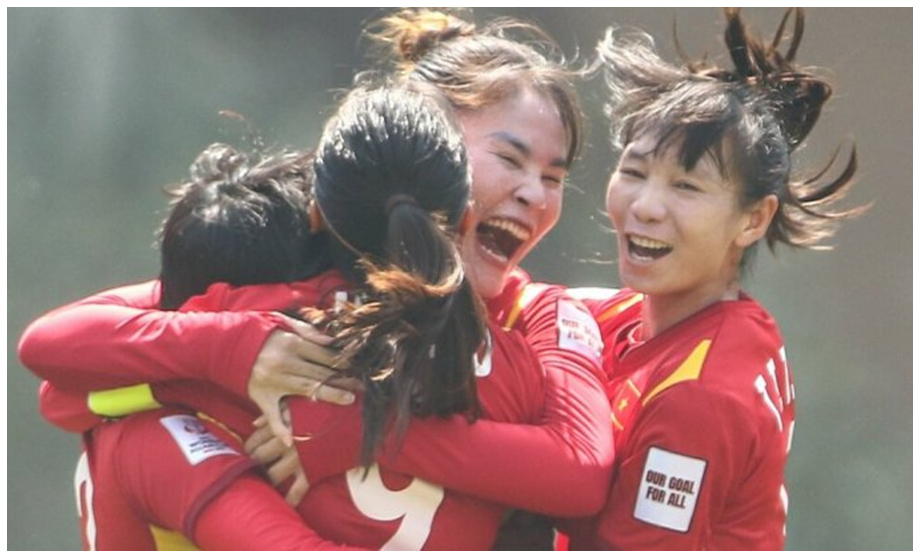

Done extract features, query from indexing bag of visual word
<Hit {'content': '45 81 43 195 118 157 1 107 125 87 144 122 61 192 6 171 36 160 110 109 38 177 121 93 170 5 103 52 118 58 115 183 193 195 36 34 135 89 105 32 190 190 162 82 185 157 94 43 24 163 163 124 95 153 69 36 49 138 93 14 102 42 69 93 127 176 65 58 64 120 107 67 150 43 61 192 173 13 147 4 4 20 193 179 193 136 143 168 92 65 190 199 194 79 131 105 82 94 51 193 67 70 58 80 98 163 146 60 143 168 143 168 16 79 58 148 128 154 177 133 57 3 195 192 80 195 45 79 41 186 186 27 83 189 177 43 115 102 93 66 21 34 193 155 132 141 108 168 31 130 109 176 115 104 195 135 33 40 189 18 7 138 45 145 157 151 56 40 75 13 109 192 117 40 34 99 197 40 106 47 113 106 86 148 163 69 1 43 34 76 58 6 44 69 117 43 176 68 171 188 49 132 54 181 162 76 49 131 50 43 167 49 138 96 102 33 191 119 47 83 28 39 162 49 49 183 33 71 133 35 88 169 183 69 38 117 68 49 109 108 79 44 18 111 95 109 33 24 177 104 6 107 85 5 183 144 76 158 33 117 92 194 42 132 192 58

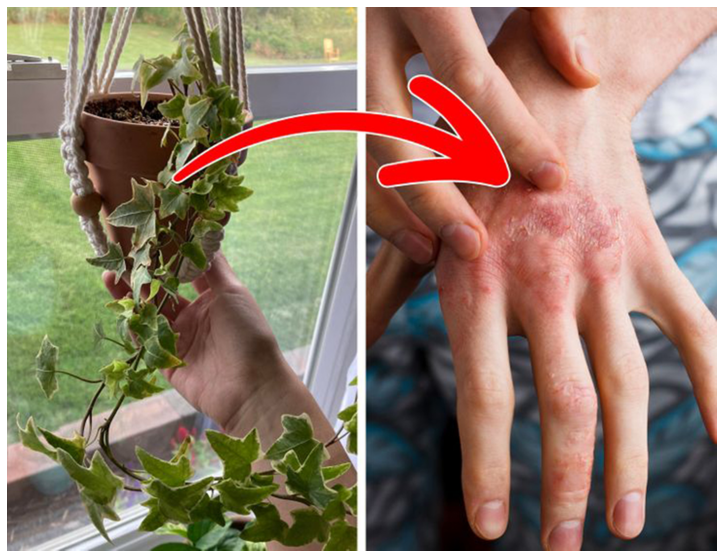

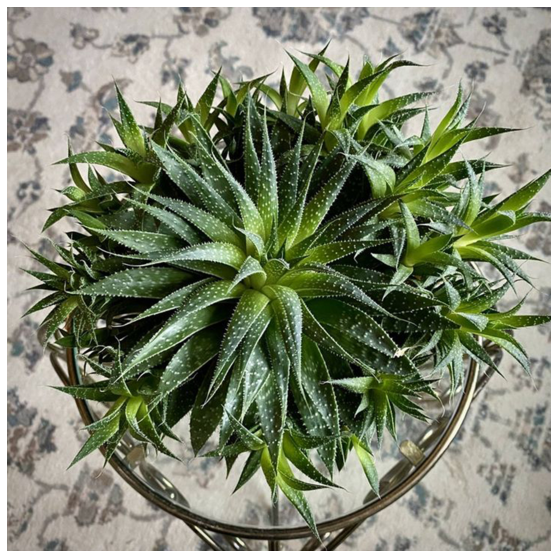

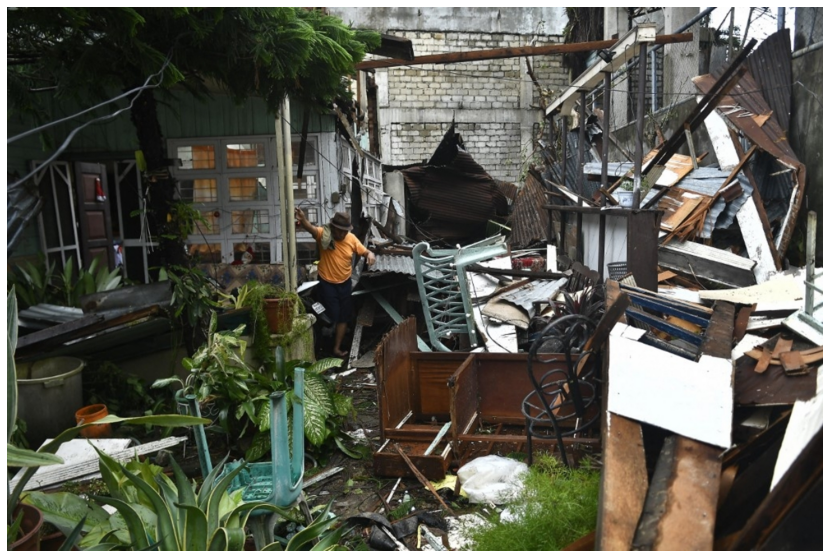

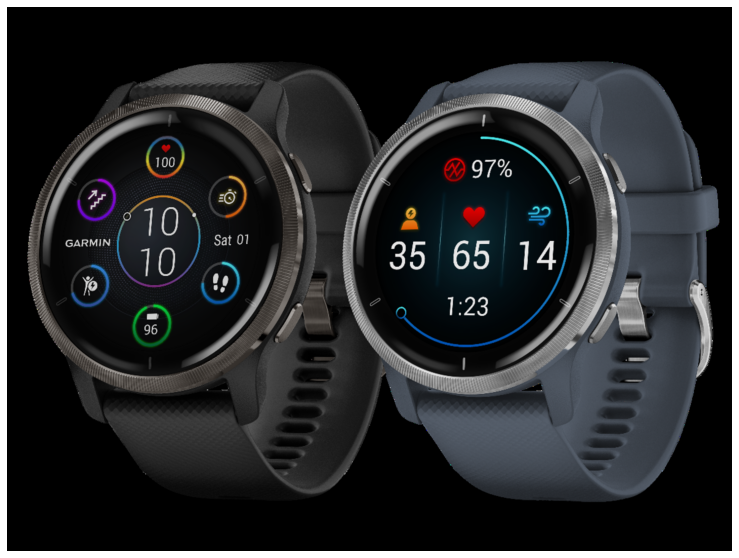

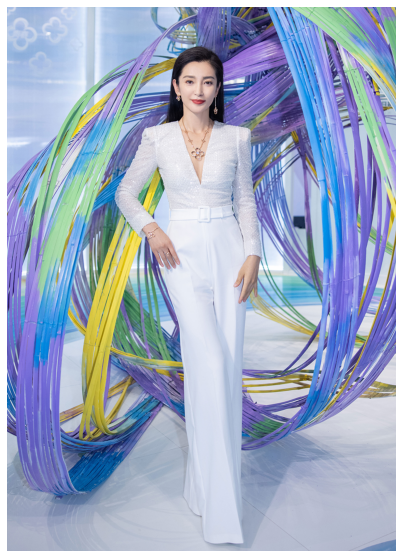

In [15]:
search_term = ""

fname = upload()

print("Uploaded done, showing image!")
imShow(os.path.join("/content", "input.jpg"))

img = cv2.imread(os.path.join("/content", "input.jpg"))
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img,None) # extract sift features from uploaded image


cluster_id = kmeans.predict(
    np.array(des)
)

search_term += " " +  (str(cluster_id))
print("Done extract features, query from indexing bag of visual word")
ans_imgs = []
with ix.searcher() as searcher:
     query = QueryParser("content", ix.schema).parse(search_term)
     results = searcher.search(query)
     print(results[0])
     ans_img = [dict(hit) for hit in results]

print("Showing result")
ans_imgs = ans_img[0:5]
print(ans_img)
for ans_img in ans_imgs: 
  fname = ans_img["path"]
  # print("ABC", ans_img["path"])
  img_path = os.path.join("/content/drive/MyDrive/Colab/data/1000-images-vnexpress/", fname)
  imShow(img_path)